In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import render_depth_map, render_texture
from text3d2video.utilities.ipython_utils import display_ims
import torchvision.transforms.functional as TF
from text3d2video.artifacts.texture_artifact import TextureArtifact
from PIL import Image

torch.set_grad_enabled(False)

In [2]:
from text3d2video.pipelines.controlnet_pipeline import BaseControlNetPipeline
from text3d2video.pipelines.pipeline_utils import load_pipeline

device = torch.device("cuda")
dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(BaseControlNetPipeline, sd_repo, controlnet_repo)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [3]:
dog_image = Image.open("data/dog.png")
prompt = "Photograph of a puppy over grass"

images = [dog_image]
prompts = [prompt]
depths = None

In [4]:
# read texture
texture_art = TextureArtifact.from_wandb_artifact_tag("texture:v21")
texture = texture_art.read_texture()

# read anim
anim = AnimationArtifact.from_wandb_artifact_tag('catwalk_180_20:latest')
cams, meshes = anim.load_frames(anim.frame_indices(10))
verts_uvs, faces_uvs = anim.uv_data()
depths = render_depth_map(meshes, cams)

# render textured frames
renders = render_texture(meshes, cams, texture, verts_uvs, faces_uvs)
renders = [TF.to_pil_image(r) for r in renders]

prompt = "Deadpool"
images = renders
prompts = [prompt] * len(images)

In [ ]:
prompts = [prompt] * len(renders)

# read anim
anim = AnimationArtifact.from_wandb_artifact_tag('human_top_down:latest')
cams, meshes = anim.load_frames()
verts_uvs, faces_uvs = anim.uv_data()
depths = render_depth_map(meshes, cams)

gen = torch.Generator(device=device).manual_seed(0)
samples = pipe(prompts, depths, num_inference_steps=10, generator=gen)

images = samples

  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (20) must match the size of tensor b (2) at non-singleton dimension 0

: 

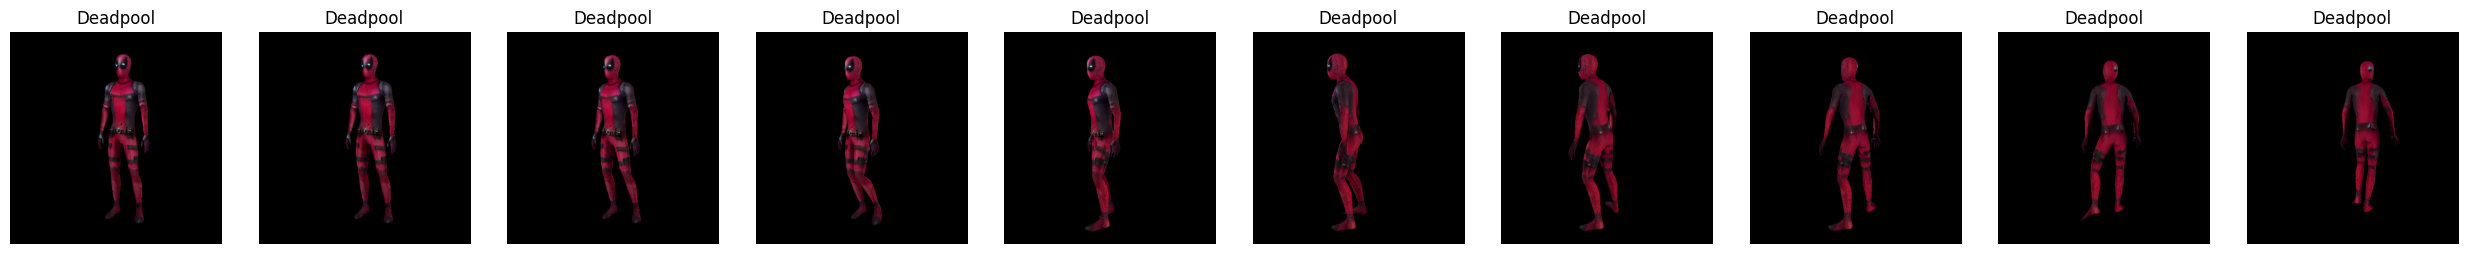

In [7]:
from text3d2video.utilities.ipython_utils import display_ims_grid


display_ims_grid([images], col_titles=prompts)

In [8]:
from tqdm import tqdm

num_inf_steps = 100
guidance_scale = 3.5
controlnet_conditioning_scale = 0

n_imgs = len(renders)
cond_embeddings, uncond_embeddings = pipe.encode_prompt(prompts)

latents = pipe.encode_images(images)
pipe.scheduler.set_timesteps(num_inf_steps)
timesteps = reversed(pipe.scheduler.timesteps)
intermediate_latents = [latents]
intermediate_ts = [0]

for i in tqdm(range(1, num_inf_steps), total=num_inf_steps - 1):
    # We'll skip the final iteration
    if i >= num_inf_steps - 1:
        print("a")
        continue

    t = timesteps[i]

    noise_pred = pipe.model_forward_cfg(
        latents,
        cond_embeddings,
        uncond_embeddings,
        t,
        depths,
    )

    current_t = max(0, t.item() - (1000 // num_inf_steps))  # t
    next_t = t  # min(999, t.item() + (1000//num_inference_steps)) # t+1
    alpha_t = pipe.scheduler.alphas_cumprod[current_t]
    alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]

    # Inverted update step (re-arranging the update step to get x(t) (new latents) as a function of x(t-1) (current latents)
    latents = (latents - (1 - alpha_t).sqrt() * noise_pred) * (
        alpha_t_next.sqrt() / alpha_t.sqrt()
    ) + (1 - alpha_t_next).sqrt() * noise_pred

    # Store
    intermediate_latents.append(latents)
    intermediate_ts.append(t.item())

intermediate_latents = torch.stack(intermediate_latents)

100%|██████████| 99/99 [00:40<00:00,  2.41it/s]

a


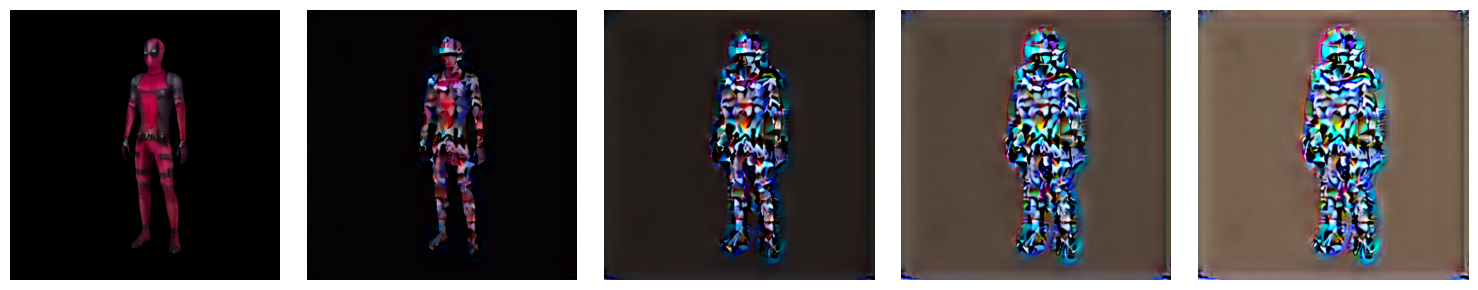

In [9]:
from text3d2video.util import ordered_sample

frame_trajectory = intermediate_latents[:, 0, ...]
sampled_trajectory = torch.stack(ordered_sample(frame_trajectory, 5))
denoised = pipe.decode_latents(sampled_trajectory)

display_ims(denoised)

101


100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


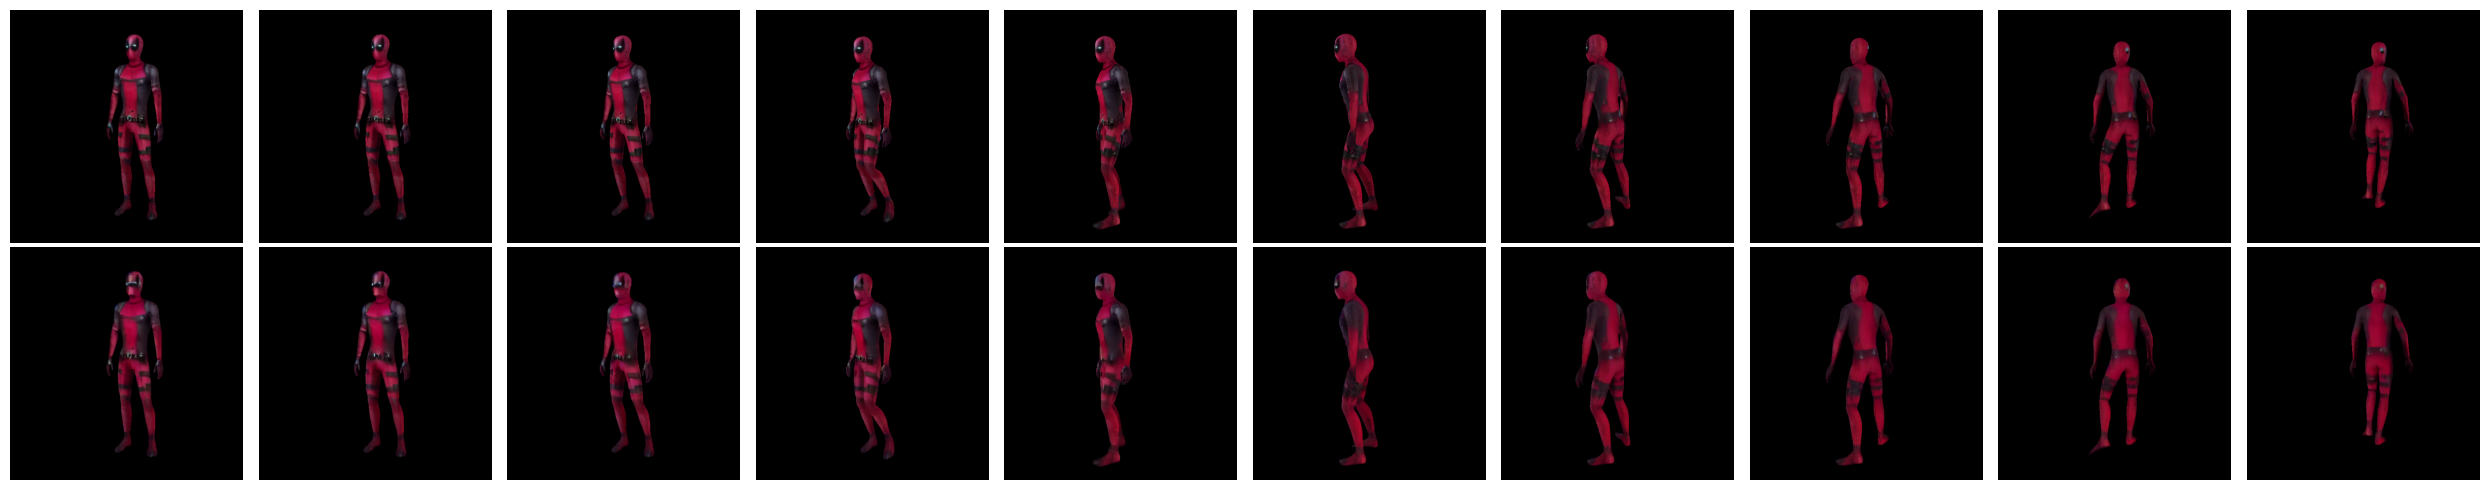

In [30]:
from text3d2video.utilities.ipython_utils import display_ims_grid


index = 10

t = intermediate_ts[index]
latents = intermediate_latents[index]

print(t)

prompt = "Deadpool"
prompts = [prompt] * len(images)
reconstructions = pipe(
    prompts, depths, num_inference_steps=10, latents=latents, t_start=t
)

display_ims_grid([images, reconstructions])

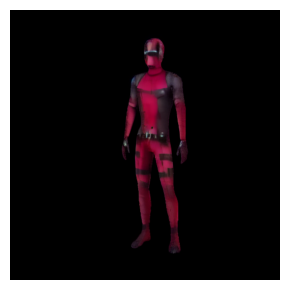

: 

In [31]:
display_ims(reconstructions[0:1])